# MNIST dataset - CNN with Max Pooling Hand Craft

In [ ]:
import tensorflow as tf


class MaxPooling(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, stride=2, n_components=1):
        super(MaxPooling, self).__init__()
        self.pool_size = pool_size
        self.stride = stride
        self.n_components = n_components

    def call(self, inputs):
        def max_pooling(feature_map):
            # Compute the region of interest
            feature_map_height = int(feature_map.shape[0])
            feature_map_width = int(feature_map.shape[1])
            feature_map_channels = int(feature_map.shape[2])

            n = feature_map_height
            m = feature_map_width

            output_matrix = []

            for i in range(0, n, self.stride):
                for j in range(0, m, self.stride):
                    # fix out of bounds
                    if i + self.pool_size > n or j + self.pool_size > m:
                        continue

                    region = feature_map[i:i +
                                         self.pool_size, j:j + self.pool_size, :]
                    output_matrix.append(
                        tf.math.reduce_max(region, axis=[0, 1]))

            output_matrix = tf.stack(output_matrix)
            return tf.reshape(output_matrix, [n // self.pool_size, m // self.pool_size, feature_map_channels])

        pooled = tf.map_fn(max_pooling, inputs, dtype=tf.float32)
        return pooled


In [ ]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.layers.pooling.base_pooling2d import Pooling2D

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys

tf.random.set_seed(9960)

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape the data to have a single channel
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Create the model
model = Sequential()
# model.add(tf.keras.layers.InputLayer((28, 28, 1), batch_size=32))
model.add(Conv2D(32, (3, 3), activation='relu',
          padding='same', input_shape=(28, 28, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling())  # replace MaxPooling2D with MaxPooling Hand Craft
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on first 50% of the training set
x_train = x_train[:int(0.5 * len(x_train))]
y_train = y_train[:int(0.5 * len(y_train))]

# x_train = x_train[0:1]
# y_train = y_train[0:1]

# Train the model
r = model.fit(x_train, y_train, batch_size=32, epochs=10,
              validation_data=(x_test, y_test))

# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc', color='red')
plt.plot(r.history['val_accuracy'], label='val_acc', color='green')
plt.legend()
plt.show()

#  Get the accuracy of the last epoch
print(f"accuracy: {r.history['accuracy'][-1]}")

for i in range(0, 6):
    img = x_test[i]
    img = np.expand_dims(img, axis=0)

    # Make prediction on individual image
    prediction = model.predict(img)

    # Get the class label with highest probability
    prediction_label = np.argmax(prediction, axis=1)

    # Get the original label of the image
    original_label = y_test[i]

    # Plot the image and the prediction
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title('Original {}, Prediction: {}'.format(
        np.where(original_label == 1)[0][0], prediction_label[0]))
    plt.show()


# MNIST dataset - CNN with BPCA Hand Craft

In [1]:
import tensorflow as tf


class BPCALayer(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, stride=2, n_components=1):
        super(BPCALayer, self).__init__()
        self.pool_size = pool_size
        self.stride = stride
        self.n_components = n_components

    def call(self, inputs):
        def max_pooling(feature_map):
            # Compute the region of interest
            feature_map_height = int(feature_map.shape[0])
            feature_map_width = int(feature_map.shape[1])
            feature_map_channels = int(feature_map.shape[2])

            h = feature_map_height
            w = feature_map_width
            c = feature_map_channels

            # Create blocks (patches)
            data = tf.reshape(
                feature_map, [1, feature_map_height, feature_map_width, feature_map_channels])
            pool_size = self.pool_size
            strides = self.stride

            patch_size = [1, pool_size, pool_size, 1]
            strides = [1, strides, strides, 1]
            patches = tf.image.extract_patches(
                images=data, sizes=patch_size, strides=strides, rates=[1, 1, 1, 1], padding='VALID')

            data = tf.reshape(patches, [h*w*8, 4])

            # Normalize the data by subtracting the mean and dividing by the standard deviation
            mean = tf.reduce_mean(data, axis=0)
            std = tf.math.reduce_std(data, axis=0)
            data = (data - mean) / std

            data = tf.where(tf.math.is_nan(data), 0.0, data)

            # Perform the Singular Value Decomposition (SVD) on the data
            s, u, v = tf.linalg.svd(data)

            # Extract the first n principal components from the matrix v
            pca_components = v[:, :self.n_components]

            # Perform the PCA transformation on the data
            transformed_data = tf.matmul(data, pca_components)

            return tf.reshape(transformed_data, [h // self.pool_size, w // self.pool_size, feature_map_channels])

        pooled = tf.map_fn(max_pooling, inputs, dtype=tf.float32)
        return pooled


11490434/11490434 [==============================] - 0s 0us/step


Instructions for updating:
Use fn_output_signature instead


Epoch 1/10
938/938 [==============================] - 114s 99ms/step - loss: 1.0489 - accuracy: 0.8074 - val_loss: 0.2249 - val_accuracy: 0.9281
Epoch 2/10
938/938 [==============================] - 91s 97ms/step - loss: 0.2596 - accuracy: 0.9225 - val_loss: 0.0892 - val_accuracy: 0.9718
Epoch 3/10
938/938 [==============================] - 92s 98ms/step - loss: 0.3959 - accuracy: 0.9338 - val_loss: 1.5880 - val_accuracy: 0.9200
Epoch 4/10
938/938 [==============================] - 91s 97ms/step - loss: 0.2905 - accuracy: 0.9450 - val_loss: 0.0699 - val_accuracy: 0.9812
Epoch 5/10
938/938 [==============================] - 91s 98ms/step - loss: 0.1925 - accuracy: 0.9591 - val_loss: 0.0771 - val_accuracy: 0.9788
Epoch 6/10
938/938 [==============================] - 91s 97ms/step - loss: 0.6564 - accuracy: 0.9353 - val_loss: 0.1356 - val_accuracy: 0.9773
Epoch 7/10
938/938 [==============================] - 90s 96ms/step - loss: 0.2484 - accuracy: 0.9626 - val_loss: 0.1009 - val_accuracy

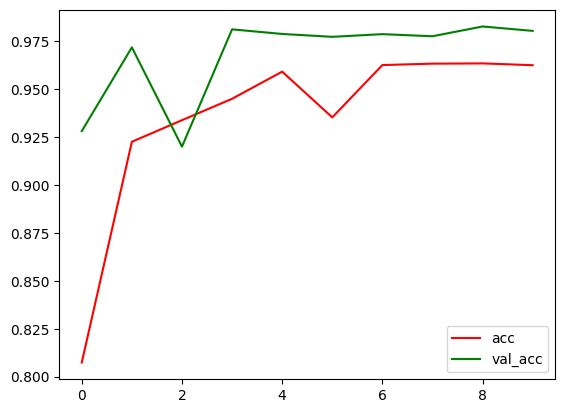

accuracy: 0.9624999761581421
1/1 [==============================] - 0s 218ms/step


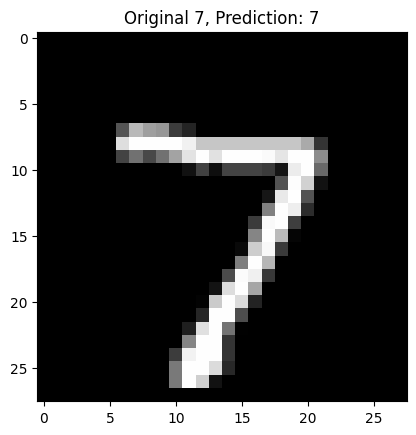

1/1 [==============================] - 0s 20ms/step


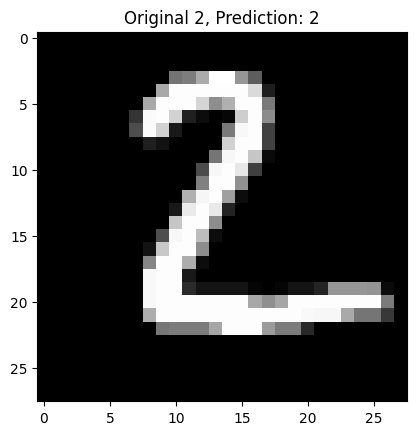

1/1 [==============================] - 0s 22ms/step


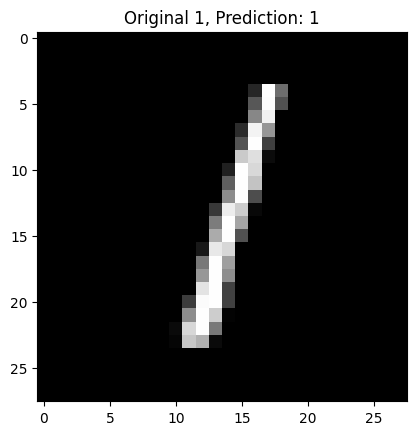

1/1 [==============================] - 0s 18ms/step


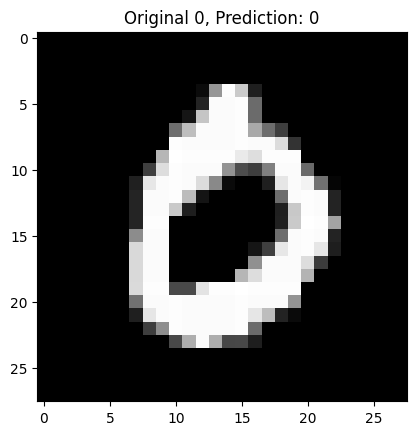

1/1 [==============================] - 0s 21ms/step


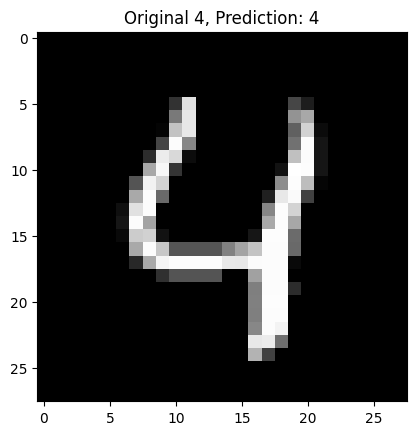

1/1 [==============================] - 0s 18ms/step


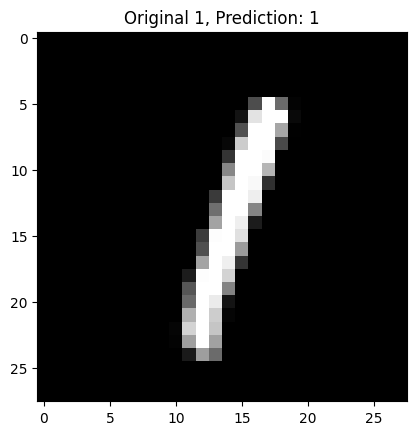

In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.layers.pooling.base_pooling2d import Pooling2D

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys

tf.random.set_seed(9960)

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape the data to have a single channel
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
          padding='same', input_shape=(28, 28, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BPCALayer())  # replace MaxPooling2D with PCALayer Hand Craft
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on first 50% of the training set
x_train = x_train[:int(0.5 * len(x_train))]
y_train = y_train[:int(0.5 * len(y_train))]

# x_train = x_train[0:1]
# y_train = y_train[0:1]

# Train the model
r = model.fit(x_train, y_train, batch_size=32, epochs=10,
              validation_data=(x_test, y_test))

# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc', color='red')
plt.plot(r.history['val_accuracy'], label='val_acc', color='green')
plt.legend()
plt.show()

#  Get the accuracy of the last epoch
print(f"accuracy: {r.history['accuracy'][-1]}")

for i in range(0, 6):
    img = x_test[i]
    img = np.expand_dims(img, axis=0)

    # Make prediction on individual image
    prediction = model.predict(img)

    # Get the class label with highest probability
    prediction_label = np.argmax(prediction, axis=1)

    # Get the original label of the image
    original_label = y_test[i]

    # Plot the image and the prediction
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title('Original {}, Prediction: {}'.format(
        np.where(original_label == 1)[0][0], prediction_label[0]))
    plt.show()
